### Connect to Drive

In [ ]:
#from google.colab import drive
#drive.mount('/gdrive')

In [ ]:
#%cd /gdrive/My Drive/ANN Exercises/Homework1

### Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2022-11-20 18:05:26.123728: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 18:05:26.266790: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-20 18:05:26.796599: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-20 18:05:26.796657: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

2.10.0


In [2]:
# Import dataset
#!unzip training_dataset_homework1.zip

# Dataset folders 
dataset_dir = 'training_data_final'

In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
labels = ['Species1', # 1
          'Species2', # 2
          'Species3', # 3
          'Species4', # 4
          'Species5', # 5
          'Species6', # 6
          'Species7', # 7
          'Species8', # 8
]

In [5]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug_train_data_gen = ImageDataGenerator(rotation_range=20, 
                                        fill_mode='reflect',
                                        #height_shift_range=20,
                                        #width_shift_range=10,
                                        brightness_range=[0.7,1.2],
                                        zoom_range=0.3,
                                        vertical_flip=True,
                                        horizontal_flip=True,
                                        validation_split=0.2
                                       )

aug_train_gen = aug_train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               subset="training",
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

no_aug_data_gen = ImageDataGenerator(validation_split=0.2)

train_gen = no_aug_data_gen.flow_from_directory(directory=dataset_dir,
                                                target_size=(96,96),
                                                color_mode='rgb',
                                                classes=labels, # can be set to labels
                                                subset="training",
                                                class_mode='categorical',
                                                batch_size=8,
                                                shuffle=True,
                                                seed=seed)

valid_gen = no_aug_data_gen.flow_from_directory(directory=dataset_dir,
                                                target_size=(96,96),
                                                color_mode='rgb',
                                                classes=labels, # can be set to labels
                                                subset="validation",
                                                class_mode='categorical',
                                                batch_size=8,
                                                shuffle=False,
                                                seed=seed)

Found 2836 images belonging to 8 classes.
Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


In [6]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}

Target classes
[0 0 0 ... 7 7 7]


In [7]:
def get_next_batch(generator):
    batch = next(generator)

    image = batch[0]
    target = batch[1]
    
    print("(Input) image shape:", image.shape)
    print("Target shape:",target.shape)

    # Visualize only the first sample
    image = image[0]
    target = target[0]
    target_idx = np.argmax(target)
    print()
    print("Categorical label:", target)
    print("Label:", target_idx)
    print("Class name:", labels[target_idx])
    fig = plt.figure(figsize=(6, 4))
    
    #image = image*255
    
    plt.imshow(np.uint8(image))

    return batch

(Input) image shape: (8, 96, 96, 3)
Target shape: (8, 8)

Categorical label: [0. 1. 0. 0. 0. 0. 0. 0.]
Label: 1
Class name: Species2


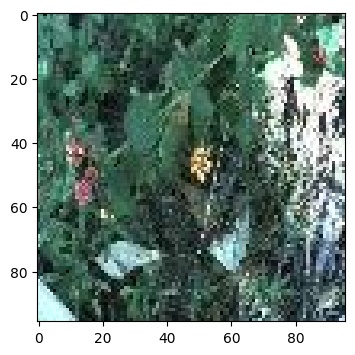

In [8]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

### Models metadata

In [9]:
input_shape = (96, 96, 3)
epochs = 200

### CNN model

In [10]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)

# Use the supernet as feature extractor
supernet.trainable = False

supernet.summary()
tfk.utils.plot_model(supernet)

2022-11-20 18:05:30.182079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 18:05:30.194053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 18:05:30.194451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 18:05:30.194922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

In [11]:
inputs = tfk.Input(shape=input_shape)
x = tfk.applications.vgg16.preprocess_input(inputs)
x = supernet(x)
x = tfkl.GlobalAveragePooling2D(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(2e-4), metrics='accuracy')

tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 96, 96, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)        0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (GlobalAveragePo  (None, 512)              0         
 oling2D)                                                        
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [12]:
# Set all VGG layers to True
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [15]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:14]):
    layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)
    
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 96, 96, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)        0         
                                                                

In [14]:
# Train the model
history = tl_model.fit(
    x = aug_train_gen,
    validation_data = valid_gen,
    epochs = epochs,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)],
).history

Epoch 1/200


2022-11-20 18:06:08.745567: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


355/355 [==============================] - 15s 38ms/step - loss: 2.1545 - accuracy: 0.1559 - val_loss: 2.0531 - val_accuracy: 0.1501
Epoch 2/200
355/355 [==============================] - 13s 36ms/step - loss: 2.0435 - accuracy: 0.1442 - val_loss: 2.0330 - val_accuracy: 0.1501
Epoch 3/200
251/355 [====================>.........] - ETA: 3s - loss: 2.0318 - accuracy: 0.1409

KeyboardInterrupt: 

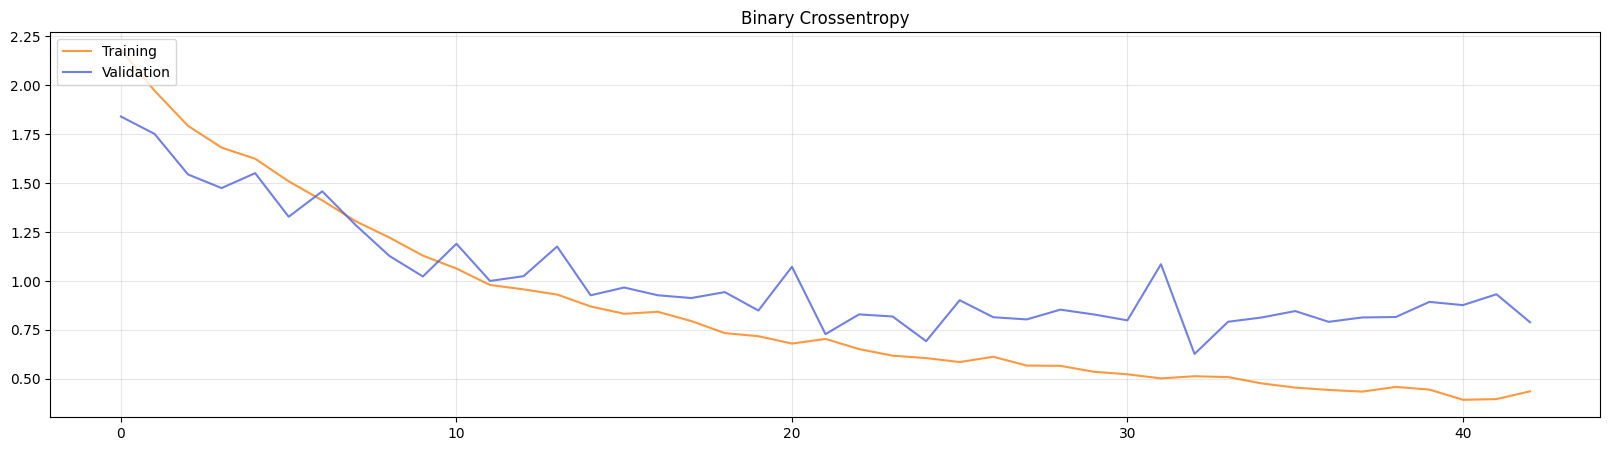

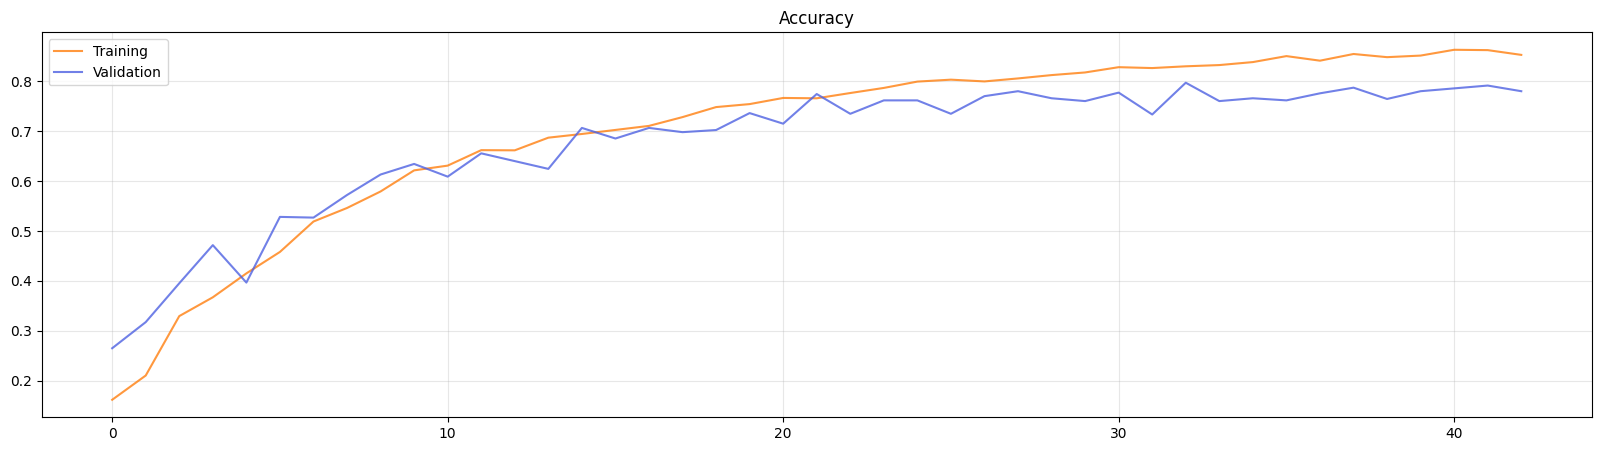

In [37]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [38]:
# Use the supernet as feature extractor
supernet.trainable = False

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.__operators__.getitem_1   (None, 96, 96, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 96, 96, 3)        0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (GlobalAveragePo  (None, 512)              0         
 oling2D)                                                        
                                                             

In [39]:
# Fine-tune the model
ft_history = tl_model.fit(
    x = train_gen,
    batch_size = 8,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
355/355 [==============================] - 8s 22ms/step - loss: 0.3365 - accuracy: 0.8791 - val_loss: 0.6281 - val_accuracy: 0.8045
Epoch 2/200
355/355 [==============================] - 8s 21ms/step - loss: 0.3323 - accuracy: 0.8865 - val_loss: 0.6409 - val_accuracy: 0.8003
Epoch 3/200
355/355 [==============================] - 8s 21ms/step - loss: 0.3352 - accuracy: 0.8868 - val_loss: 0.6477 - val_accuracy: 0.7960
Epoch 4/200
355/355 [==============================] - 8s 21ms/step - loss: 0.3225 - accuracy: 0.8868 - val_loss: 0.6393 - val_accuracy: 0.8031
Epoch 5/200
355/355 [==============================] - 8s 21ms/step - loss: 0.3223 - accuracy: 0.8780 - val_loss: 0.6401 - val_accuracy: 0.8045
Epoch 6/200
355/355 [==============================] - 8s 21ms/step - loss: 0.3092 - accuracy: 0.8882 - val_loss: 0.6481 - val_accuracy: 0.8017
Epoch 7/200
355/355 [==============================] - 8s 22ms/step - loss: 0.3009 - accuracy: 0.8893 - val_loss: 0.6530 - val_accuracy:

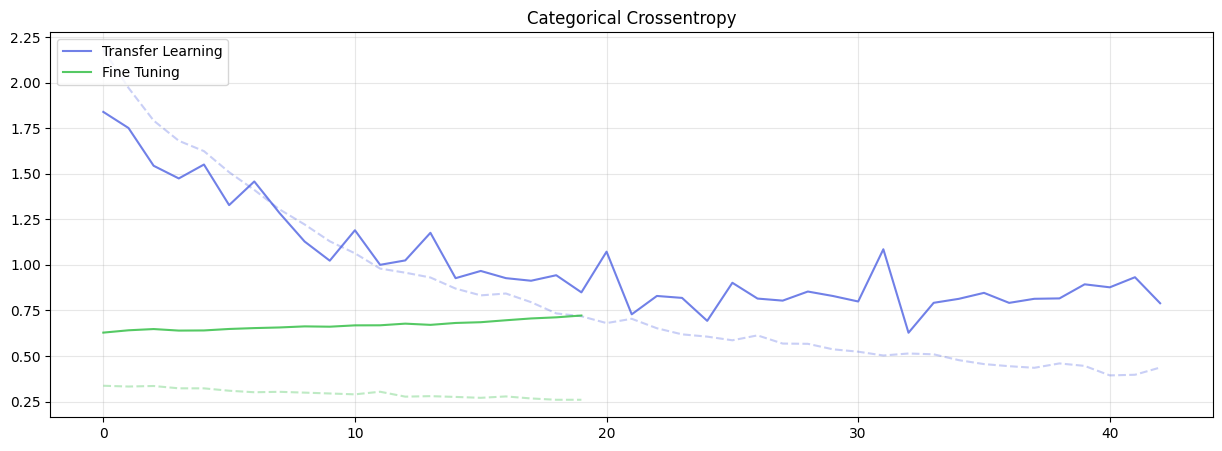

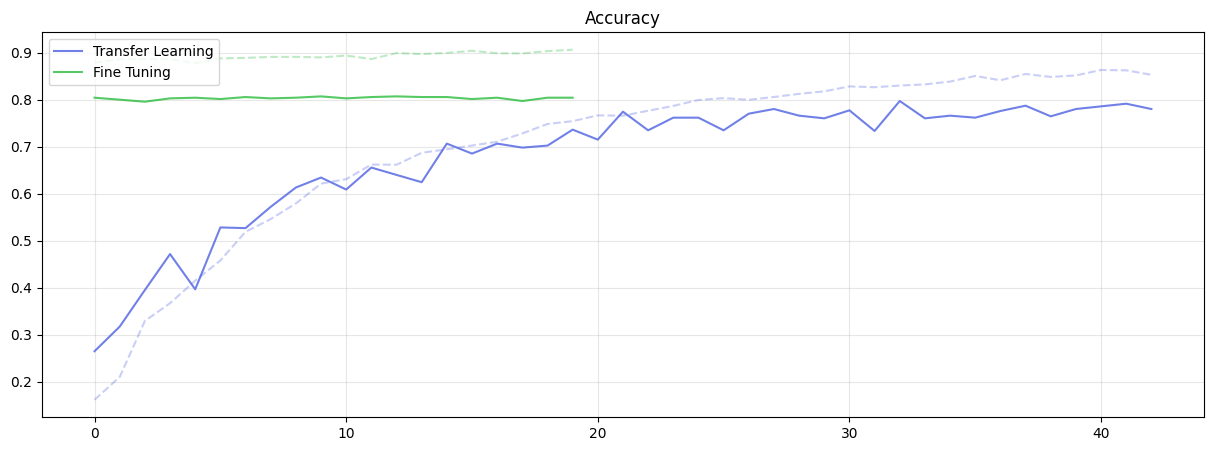

In [40]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [41]:
from sklearn.metrics import classification_report

def evaluate_classes_performance(model, validation_dataset):

    data_list = []
    label_list = []
    batch_index = 0

    while batch_index <= validation_dataset.batch_index:
        data = validation_dataset.next()

        for i in range(len(data[0])):
            data_list.append(data[0][i])
            label_list.append(data[1][i])

        batch_index = batch_index + 1

    data_array = np.array(data_list)
    label_array = np.array(label_list)   
    label_values = np.argmax(label_array, axis=1)
    predictions = tl_model.predict(data_array)
    predictions = np.argmax(predictions, axis=1)
    
    report = classification_report(label_values, predictions)
    print(report)

In [42]:
evaluate_classes_performance(tl_model, valid_gen)

23/23 [==============================] - 1s 38ms/step
              precision    recall  f1-score   support

           0       0.64      0.38      0.47        37
           1       0.79      0.87      0.83       106
           2       0.82      0.82      0.82       103
           3       0.75      0.84      0.80       102
           4       0.82      0.81      0.82       106
           5       0.78      0.73      0.75        44
           6       0.94      0.95      0.95       107
           7       0.76      0.73      0.74       101

    accuracy                           0.81       706
   macro avg       0.79      0.77      0.77       706
weighted avg       0.80      0.81      0.80       706



In [26]:
tl_model.save('ANN_Homework1_Model')

23/23 [==============================] - 1s 38ms/step
              precision    recall  f1-score   support

           0       0.59      0.59      0.59        37
           1       0.78      0.89      0.83       106
           2       0.83      0.83      0.83       103
           3       0.78      0.89      0.83       102
           4       0.86      0.80      0.83       106
           5       0.84      0.73      0.78        44
           6       0.95      0.91      0.93       107
           7       0.82      0.73      0.77       101

    accuracy                           0.82       706
   macro avg       0.81      0.80      0.80       706
weighted avg       0.82      0.82      0.82       706



In [ ]:
import shutil
tl_model.save('ANN_Homework1_Model')
shutil.make_archive("ANN_Homework1_Model", 'zip', '/kaggle/working/ANN_Homework1_Model')

In [19]:
tl_model.get_layer('vgg16').trainable = False

In [24]:
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 96, 96, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)        0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (GlobalAveragePo  (None, 512)              0         
 oling2D)                                                        
                                                                 
 dropout (Dropout)           (None, 512)               0     